# Casos de dengue no Brasil

## Análise complementar da BD Letter de março/2025

Neste notebook, investigamos os casos de dengue, óbito e população. Um subset por ano traz um retrato mais detalhado de 2024 e 2025.

In [ ]:
!pip install basedosdados==2.0.0b16 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.38.0 requires pandas-gbq>=0.26.0, but you have pandas-gbq 0.19.2 which is incompatible.


In [ ]:
import pandas as pd
import basedosdados as bd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Casos de dengue, óbitos e população

Consulta em SQL. Substitua o billing_project_id pelo seu billing_project_id (ver instruções [aqui](https://https://basedosdados.org/blog/como-comecar-sua-analise-com-dados-publicos) se necessário).

- Aqui, vou pegar os casos de notificação de casos e óbitos de dengue e informações de população. Como ainda não temos dados de população na BD para além de 2022, vou fazer uma consulta separada para 2023, 2024 e 2025 e copiar as informações de população de 2022.

In [ ]:
consulta = """
SELECT dengue.ano,
id_municipio_notificacao,
COUNT(tipo_notificacao) AS total_casos,
COUNT(CASE WHEN evolucao_caso = '2' THEN 1 END) AS total_obitos,
populacao
FROM `basedosdados.br_ms_sinan.microdados_dengue` dengue
JOIN `basedosdados.br_ibge_populacao.municipio` pop
ON dengue.id_municipio_notificacao = pop.id_municipio and dengue.ano = pop.ano
WHERE dengue.ano <= 2022
AND classificacao_final IN ("10", "11", "12")
AND tipo_notificacao = "2"
GROUP BY ano, id_municipio_notificacao, populacao;
"""
df1 = bd.read_sql(consulta, billing_project_id = 'eleicoes-434413')

Downloading: 100%|██████████|


In [ ]:
df1.head(5)

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao
0,2015,3541406,3391,5,222192
1,2015,3506003,8828,7,366992
2,2015,3504008,4776,3,101597
3,2015,3556008,139,0,13504
4,2015,3536505,3307,0,97702


Casos de 2023, 2024 e 2025

In [ ]:
consulta = """
SELECT
  ano,
  id_municipio_notificacao,
  COUNT(tipo_notificacao) AS total_casos,
  COUNT(CASE WHEN evolucao_caso = '2' THEN 1 END) AS total_obitos
FROM `basedosdados.br_ms_sinan.microdados_dengue` dengue
WHERE dengue.ano >= 2023
AND dengue.classificacao_final IN ("10", "11", "12")
AND dengue.tipo_notificacao = "2"
GROUP BY ano, id_municipio_notificacao;
"""
df2 = bd.read_sql(consulta, billing_project_id = 'eleicoes-434413')

Downloading: 100%|██████████|


In [ ]:
df2.head(5)

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao
0,2023,2704302,2458,1,960667
1,2023,1200203,796,1,94345
2,2023,1301803,457,0,24387
3,2023,1200344,56,0,12246
4,2023,1200252,15,0,18697


In [ ]:
# Pegando a população de 2022 para cada município
pop_2022 = df1[df1['ano'] == 2022][['id_municipio_notificacao', 'populacao']]

In [ ]:
# Juntando os dados de 2023+ com a população de 2022, usando merge no município
df2 = df2.merge(pop_2022, on='id_municipio_notificacao', how='left')

In [ ]:
# Concatenando os dois dataframes
df_final = pd.concat([df1, df2], ignore_index=True)

In [ ]:
# Ordenando a série histórica
df_final = df_final.sort_values(by=['id_municipio_notificacao', 'ano'])

In [ ]:
df_final.head(20)

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao,casos_por_100k
7876,2014,1100015,8,0,25652,31.186652
15799,2015,1100015,10,0,25578,39.096098
11375,2016,1100015,11,0,25506,43.127107
27630,2017,1100015,9,0,25437,35.381531
22296,2018,1100015,1,0,23167,4.316485
2527,2019,1100015,227,0,22945,989.322292
7097,2020,1100015,3,0,22728,13.199578
4396,2021,1100015,2,0,22516,8.882572
21120,2022,1100015,365,0,21558,1693.106967
30224,2023,1100015,379,1,21558,1758.048056


Acrescentando os casos de dengue por 100 mil habitantes

In [ ]:
df_final['casos_por_100k'] = (df_final['total_casos'] / df_final['populacao']) * 100000

## Rankings por subset de anos

### 2024

In [ ]:
# Filtrando os dados para 2024 e 2025
dados_2024 = df_final.loc[df_final['ano'] == 2024]

Ranking geral

In [ ]:
ranking_2024 = dados_2024.sort_values(by=['total_casos'], ascending=[False])

In [ ]:
ranking_2024.head(5)

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao,casos_por_100k
39685,2024,3550308,652225,581,12200180,5346.027682
32893,2024,3106200,233365,181,2392678,9753.297351
33784,2024,5300108,200808,460,2923369,6869.061005
36772,2024,3509502,127582,98,1170247,10902.142881
33313,2024,3304557,111143,26,6625849,1677.415226


Ranking casos por 100 mil habitantes

In [ ]:
ranking_2024_100k = dados_2024.sort_values(by=['casos_por_100k'], ascending=[False])

In [ ]:
ranking_2024_100k.head(5)

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao,casos_por_100k
37026,2024,4110052,805,0,2142,37581.699346
33462,2024,4103057,2817,4,7876,35766.886745
30453,2024,4101002,6188,9,19506,31723.572234
30498,2024,4115101,2960,4,9846,30062.969734
39880,2024,4120358,1703,6,5705,29851.007888


Ranking de óbitos

In [ ]:
ranking_2024_obitos = dados_2024.sort_values(by=['total_obitos'], ascending=[False])

In [ ]:
ranking_2024_obitos.head(5)

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao,casos_por_100k
39685,2024,3550308,652225,581,12200180,5346.027682
33784,2024,5300108,200808,460,2923369,6869.061005
32893,2024,3106200,233365,181,2392678,9753.297351
36770,2024,3549904,100019,125,725419,13787.755766
33837,2024,3518800,67976,109,1383272,4914.145591


#### Por capitais em 2024

In [ ]:
# Por capitais

# Lista de códigos IBGE das capitais
codigos_capitais = [
    "1200401", "2704302", "1600303", "1302603", "2927408", "2304400", "5300108",
    "3205309", "5208707", "2111300", "5103403", "5002704", "3106200", "1501402",
    "2507507", "4106902", "2611606", "2211001", "3304557", "2408102", "4314902",
    "1100205", "1400100", "4205407", "3550308", "2800308", "1721000"
]

# Filtrar apenas as capitais
dados_2024_capitais = dados_2024.loc[dados_2024['id_municipio_notificacao'].isin(codigos_capitais)]

In [ ]:
ranking_capitais_100k = dados_2024_capitais.sort_values(by=['casos_por_100k'], ascending=[False])

In [ ]:
ranking_capitais_100k.head(5)

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao,casos_por_100k
32893,2024,3106200,233365,181,2392678,9753.297351
33784,2024,5300108,200808,460,2923369,6869.061005
39685,2024,3550308,652225,581,12200180,5346.027682
39340,2024,5208707,51922,102,1414483,3670.740475
39571,2024,4205407,12581,23,574200,2191.048415


### 2025

In [ ]:
# Filtrando os dados para 2025
dados_2025 = df_final.loc[df_final['ano'] == 2025]

Ranking geral

In [ ]:
ranking_2025 = dados_2025.sort_values(by=['total_casos'], ascending=[False])

In [ ]:
ranking_2025.head(5)

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao,casos_por_100k
40283,2025,3549805,24775,30,475643,5208.738487
31421,2025,3550308,8711,1,12200180,71.400586
37293,2025,3530706,8397,13,154487,5435.408805
34405,2025,3502804,8271,5,213929,3866.235994
31438,2025,3170206,4870,3,725536,671.227892


Ranking casos por 100 mil habitantes

In [ ]:
ranking_2025_100k = ranking_2025.sort_values(by=['casos_por_100k'], ascending=[False])

In [ ]:
ranking_2025_100k.head(5)

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao,casos_por_100k
31542,2025,3503950,253,0,1860,13602.150538
31461,2025,3512308,1856,2,17184,10800.744879
34419,2025,3509809,467,0,4837,9654.744676
34483,2025,3547650,149,0,1644,9063.260341
31538,2025,3532843,163,0,2031,8025.603151


Ranking de óbitos

In [ ]:
ranking_2025_obitos = dados_2025.sort_values(by=['total_obitos'], ascending=[False])

In [ ]:
ranking_2025_obitos.head(5)

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao,casos_por_100k
40283,2025,3549805,24775,30,475643,5208.738487
37293,2025,3530706,8397,13,154487,5435.408805
34423,2025,3501905,2778,8,69952,3971.294602
40344,2025,3524303,1344,8,72001,1866.640741
37326,2025,3551702,4684,7,127670,3668.833712


# Análise teste: casos, óbitos e letalidade por porte de município

In [ ]:
# Classificação dos municípios por porte
bins = [0, 20000, 100000, 500000, float('inf')]  # Definição dos limites
labels = ['Pequeno Porte', 'Médio Porte', 'Grande Porte', 'Metrópole']

# classificação do IBGE

[df_final foi o que criamos no início do notebook!]

In [ ]:
df_final['porte_municipio'] = pd.cut(df_final['populacao'], bins=bins, labels=labels)

In [ ]:
df_final.head(5)

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao,porte_municipio
14611,2014,1100015,8,0,25652,Médio Porte
1809,2015,1100015,10,0,25578,Médio Porte
23813,2016,1100015,11,0,25506,Médio Porte
10125,2017,1100015,9,0,25437,Médio Porte
8499,2018,1100015,1,0,23167,Médio Porte


In [ ]:
df_porte = df_final.groupby(['ano', 'porte_municipio']).agg({
    'total_casos': ['sum', 'mean', 'median', 'std', 'min', 'max'],
    'total_obitos': ['sum', 'mean', 'median', 'std', 'min', 'max']
}).reset_index()

In [ ]:
df_porte

ano porte_municipio total_casos                                        \
                                 sum          mean   median            std   
0   2014   Pequeno Porte       38393     30.912238      6.0      89.347223   
1   2014     Médio Porte      131330     164.36796     17.0    1016.537984   
2   2014    Grande Porte      133086    594.133929     98.0     1342.53516   
3   2014       Metrópole      155237   3980.435897    876.0      8446.9337   
4   2015   Pequeno Porte      129759     66.406858     14.0     145.512825   
5   2015     Médio Porte      344026    313.320583     59.0      713.85279   
6   2015    Grande Porte      431764   1748.032389    641.0    3444.336775   
7   2015       Metrópole      418269  10201.682927   3742.0   15805.486032   
8   2016   Pequeno Porte       94767     43.631215     10.0     113.707577   
9   2016     Médio Porte      246431    216.547452     41.0     540.418229   
10  2016    Grande Porte      321108   1216.318182    190.5    2738.536173   
11  2016       Metrópole      402844   9825.463415   1883.0   25026.074177   
12  2017   Pequeno Porte       15992     12.732484      3.0      40.465263   
13  2017     Médio Porte       40942     45.796421      7.5      141.78771   
14  2017    Grande Porte       41528    175.966102     28.0      377.13527   
15  2017       Metrópole       69142   1646.238095    421.0    3417.929938   
16  2018   Pequeno Porte       24655     18.593514      3.0      50.868709   
17  2018     Médio Porte       53778     63.119718      7.0     235.213556   
18  2018    Grande Porte       50830     220.04329     21.0     557.840625   
19  2018       Metrópole       69139   1536.422222    332.0    3505.290012   
20  2019   Pequeno Porte      146442     62.025413     16.0     121.935591   
21  2019     Médio Porte      295706    251.237043     44.0     594.478209   
22  2019    Grande Porte      405364   1501.348148    196.0    4377.749077   
23  2019       Metrópole      464232        9671.5   1869.5   19022.719092   
24  2020   Pequeno Porte      159564     72.529091     13.0     174.029397   
25  2020     Médio Porte      256519    230.268402     29.5     657.405463   
26  2020    Grande Porte      202862    774.282443     98.5     2016.13066   
27  2020       Metrópole      174065   3626.354167    867.0     7902.61048   
28  2021   Pequeno Porte       69818       37.5972      5.0     103.846939   
29  2021     Médio Porte      114032    106.971857     14.0     271.756659   
30  2021    Grande Porte      142443    556.417969     66.5    2030.393763   
31  2021       Metrópole      121591   2587.042553    385.0    4481.001848   
32  2022   Pequeno Porte      252264     92.404396     22.0     205.647709   
33  2022     Médio Porte      354733    295.364696     46.0     761.867134   
34  2022    Grande Porte      332107   1272.440613    232.0    2941.281805   
35  2022       Metrópole      304246   7075.488372   1569.0   12305.093288   
36  2023   Pequeno Porte      204518     94.204514     16.0     223.831105   
37  2023     Médio Porte      359259    323.656757     43.0     761.852847   
38  2023    Grande Porte      358608   1373.977011    296.0    3501.679301   
39  2023       Metrópole      358705   8341.976744   2458.0    11548.79952   
40  2024   Pequeno Porte      677292    269.622611     71.0     490.424852   
41  2024     Médio Porte     1296407   1096.791032    194.5    2010.469693   
42  2024    Grande Porte     1633764   6259.632184   2703.0    9019.860719   
43  2024       Metrópole     2070782   48157.72093  12570.0  107617.944281   
44  2025   Pequeno Porte       28770     26.012658      4.0      67.789999   
45  2025     Médio Porte       49154     67.150273      7.5     251.808532   
46  2025    Grande Porte       59166    245.502075     19.0     1171.06553   
47  2025       Metrópole       26125     607.55814    121.0    1072.267364   

                total_obitos                                        
    min     max          sum       

## Analisando o caso de Curitiba separadamente

In [ ]:
df_curitiba = df_final[df_final['id_municipio_notificacao'] == "4106902"]

In [ ]:
df_curitiba

,ano,id_municipio_notificacao,total_casos,total_obitos,populacao,porte_municipio
26660,2014,4106902,64,0,1864416,Metrópole
1762,2015,4106902,296,0,1879355,Metrópole
22046,2016,4106902,867,5,1893997,Metrópole
2808,2017,4106902,35,0,1908359,Metrópole
23002,2018,4106902,37,0,1917185,Metrópole
5094,2019,4106902,117,0,1933105,Metrópole
24205,2020,4106902,301,0,1948626,Metrópole
16705,2021,4106902,49,0,1963726,Metrópole
13720,2022,4106902,239,0,1871789,Metrópole
32029,2023,4106902,746,1,1871789,Metrópole


<Axes: xlabel='ano', ylabel='total_casos'>

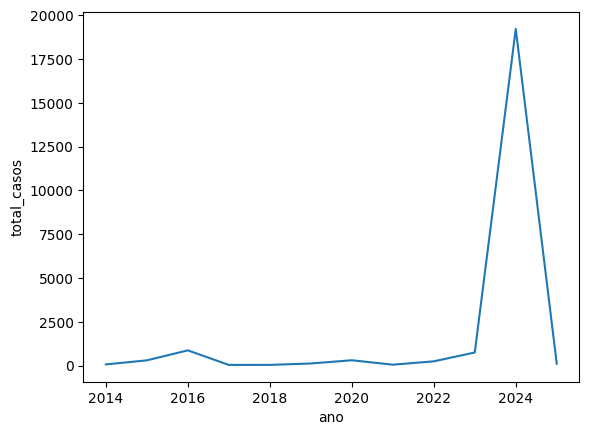

In [ ]:
sns.lineplot(data = df_curitiba, x = 'ano', y = 'total_casos')

# Número de casos por semana epidemiológica

## Sorocaba, Americana e Curitiba

- Modifique os filtros para a sua cidade

In [ ]:
consulta = """
SELECT ano, id_municipio_notificacao, semana_notificacao, COUNT(tipo_notificacao) as casos_dengue
FROM `basedosdados.br_ms_sinan.microdados_dengue` as dengue
WHERE id_municipio_notificacao IN ("4106902", "3552205", "3501608")
AND tipo_notificacao = "2"
AND classificacao_final IN ("10", "11", "12")
GROUP BY dengue.ano, semana_notificacao, id_municipio_notificacao
ORDER BY ano, id_municipio_notificacao DESC
"""
df_semana = bd.read_sql(consulta, billing_project_id = 'eleicoes-434413')

Downloading: 100%|██████████|


In [ ]:
df_semana.head(10)

,ano,id_municipio_notificacao,semana_notificacao,casos_dengue
0,2014,4106902,2014-12,2
1,2014,4106902,2014-20,7
2,2014,4106902,2014-05,1
3,2014,4106902,2014-09,3
4,2014,4106902,2014-02,1
5,2014,4106902,2014-15,1
6,2014,4106902,2014-32,1
7,2014,4106902,2014-03,1
8,2014,4106902,2014-17,7
9,2014,4106902,2014-11,2


In [ ]:
# split the Name column into two columns
df_semana[['ano', 'semana_notificacao']] = df_semana['semana_notificacao'].str.split('-', expand=True)

In [ ]:
df_semana.loc[df_semana['id_municipio_notificacao'] == '4106902', 'id_municipio_notificacao'] = 'Curitiba'
df_semana.loc[df_semana['id_municipio_notificacao'] == '3552205', 'id_municipio_notificacao'] = 'Sorocaba'
df_semana.loc[df_semana['id_municipio_notificacao'] == '3501608', 'id_municipio_notificacao'] = 'Americana'

In [ ]:
df_curitiba = df_semana[df_semana['id_municipio_notificacao'] == 'Curitiba']
df_sorocaba = df_semana[df_semana['id_municipio_notificacao'] == 'Sorocaba']
df_americana = df_semana[df_semana['id_municipio_notificacao'] == 'Americana']

## Caso de Curitiba

In [ ]:
df_curitiba.head(5)

,ano,id_municipio_notificacao,semana_notificacao,casos_dengue
0,2014,Curitiba,12,2
1,2014,Curitiba,20,7
2,2014,Curitiba,05,1
3,2014,Curitiba,09,3
4,2014,Curitiba,02,1


In [ ]:
df_curitiba = df_curitiba.sort_values(by="semana_notificacao", ascending=True)

In [ ]:
# Lista de anos únicos no dataframe
anos = df_curitiba["ano"].unique()

# Definir as cores: cinza para todos, exceto 2024 e 2025
cores = {ano: "gray" for ano in anos}
cores['2024'] = "blue"  # Cor diferente para 2024
cores['2025'] = "red"   # Cor diferente para 2025

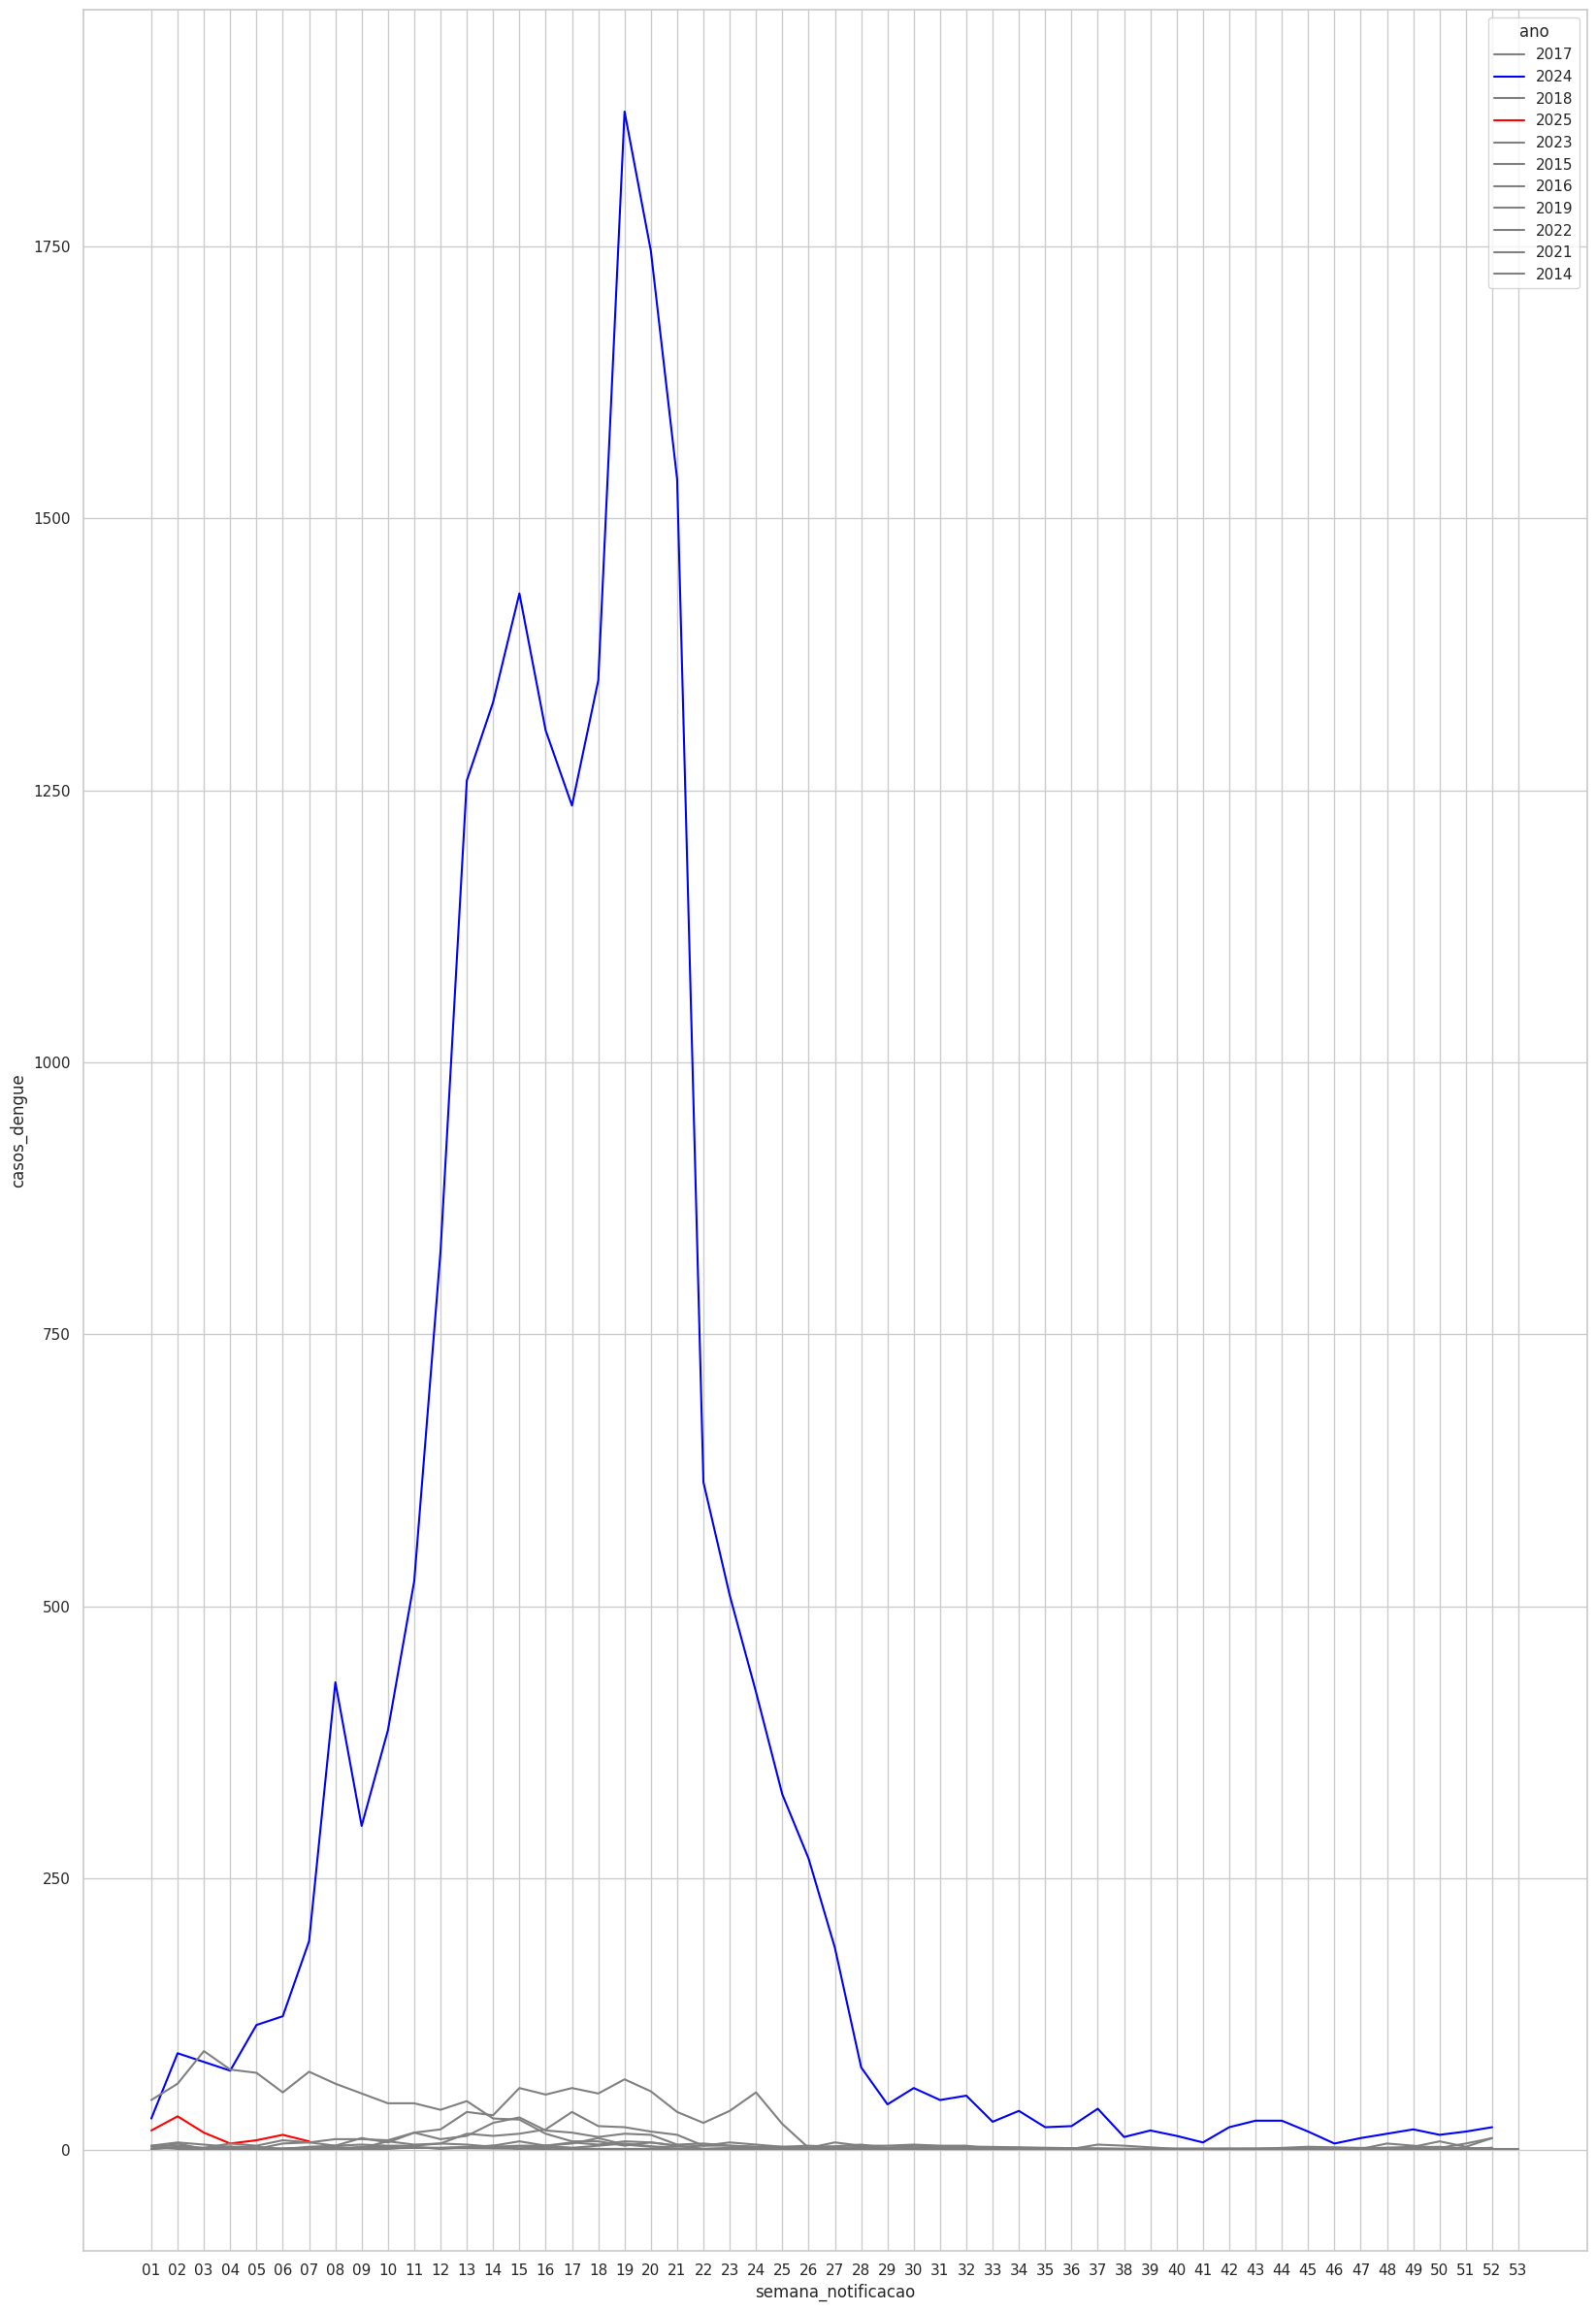

In [ ]:
sns.lineplot(data = df_curitiba, x = 'semana_notificacao', y = 'casos_dengue', hue = 'ano', palette = cores)
sns.set_theme(style="whitegrid", rc={'figure.figsize':(20,50)})

## Consultando o caso de Palmas

In [ ]:
consulta = """
SELECT ano, id_municipio_notificacao, semana_notificacao, COUNT(tipo_notificacao) as casos_dengue
FROM `basedosdados.br_ms_sinan.microdados_dengue` as dengue
WHERE id_municipio_notificacao = "1721000"
AND tipo_notificacao = "2"
AND classificacao_final IN ("10", "11", "12")
GROUP BY dengue.ano, semana_notificacao, id_municipio_notificacao
ORDER BY ano, id_municipio_notificacao DESC
"""
df_semana_palmas = bd.read_sql(consulta, billing_project_id = 'eleicoes-434413')

Downloading: 100%|██████████|


In [ ]:
df_semana_palmas

,ano,id_municipio_notificacao,semana_notificacao,casos_dengue
0,2014,1721000,04,21
1,2014,1721000,49,23
2,2014,1721000,40,12
3,2014,1721000,07,51
4,2014,1721000,35,5
...,...,...,...,...
505,2025,1721000,05,4
506,2025,1721000,04,2
507,2025,1721000,02,1
508,2025,1721000,03,1


In [ ]:
# split the Name column into two columns
df_semana_palmas[['ano', 'semana_notificacao']] = df_semana_palmas['semana_notificacao'].str.split('-', expand=True)

In [ ]:
df_semana_palmas = df_semana_palmas.sort_values(by="semana_notificacao", ascending=True)

In [ ]:
# Lista de anos únicos no dataframe
anos = df_semana_palmas["ano"].unique()

# Definir as cores: cinza para todos, exceto 2024 e 2025
cores = {ano: "gray" for ano in anos}
cores['2024'] = "blue"  # Cor diferente para 2024
cores['2025'] = "red"   # Cor diferente para 2025

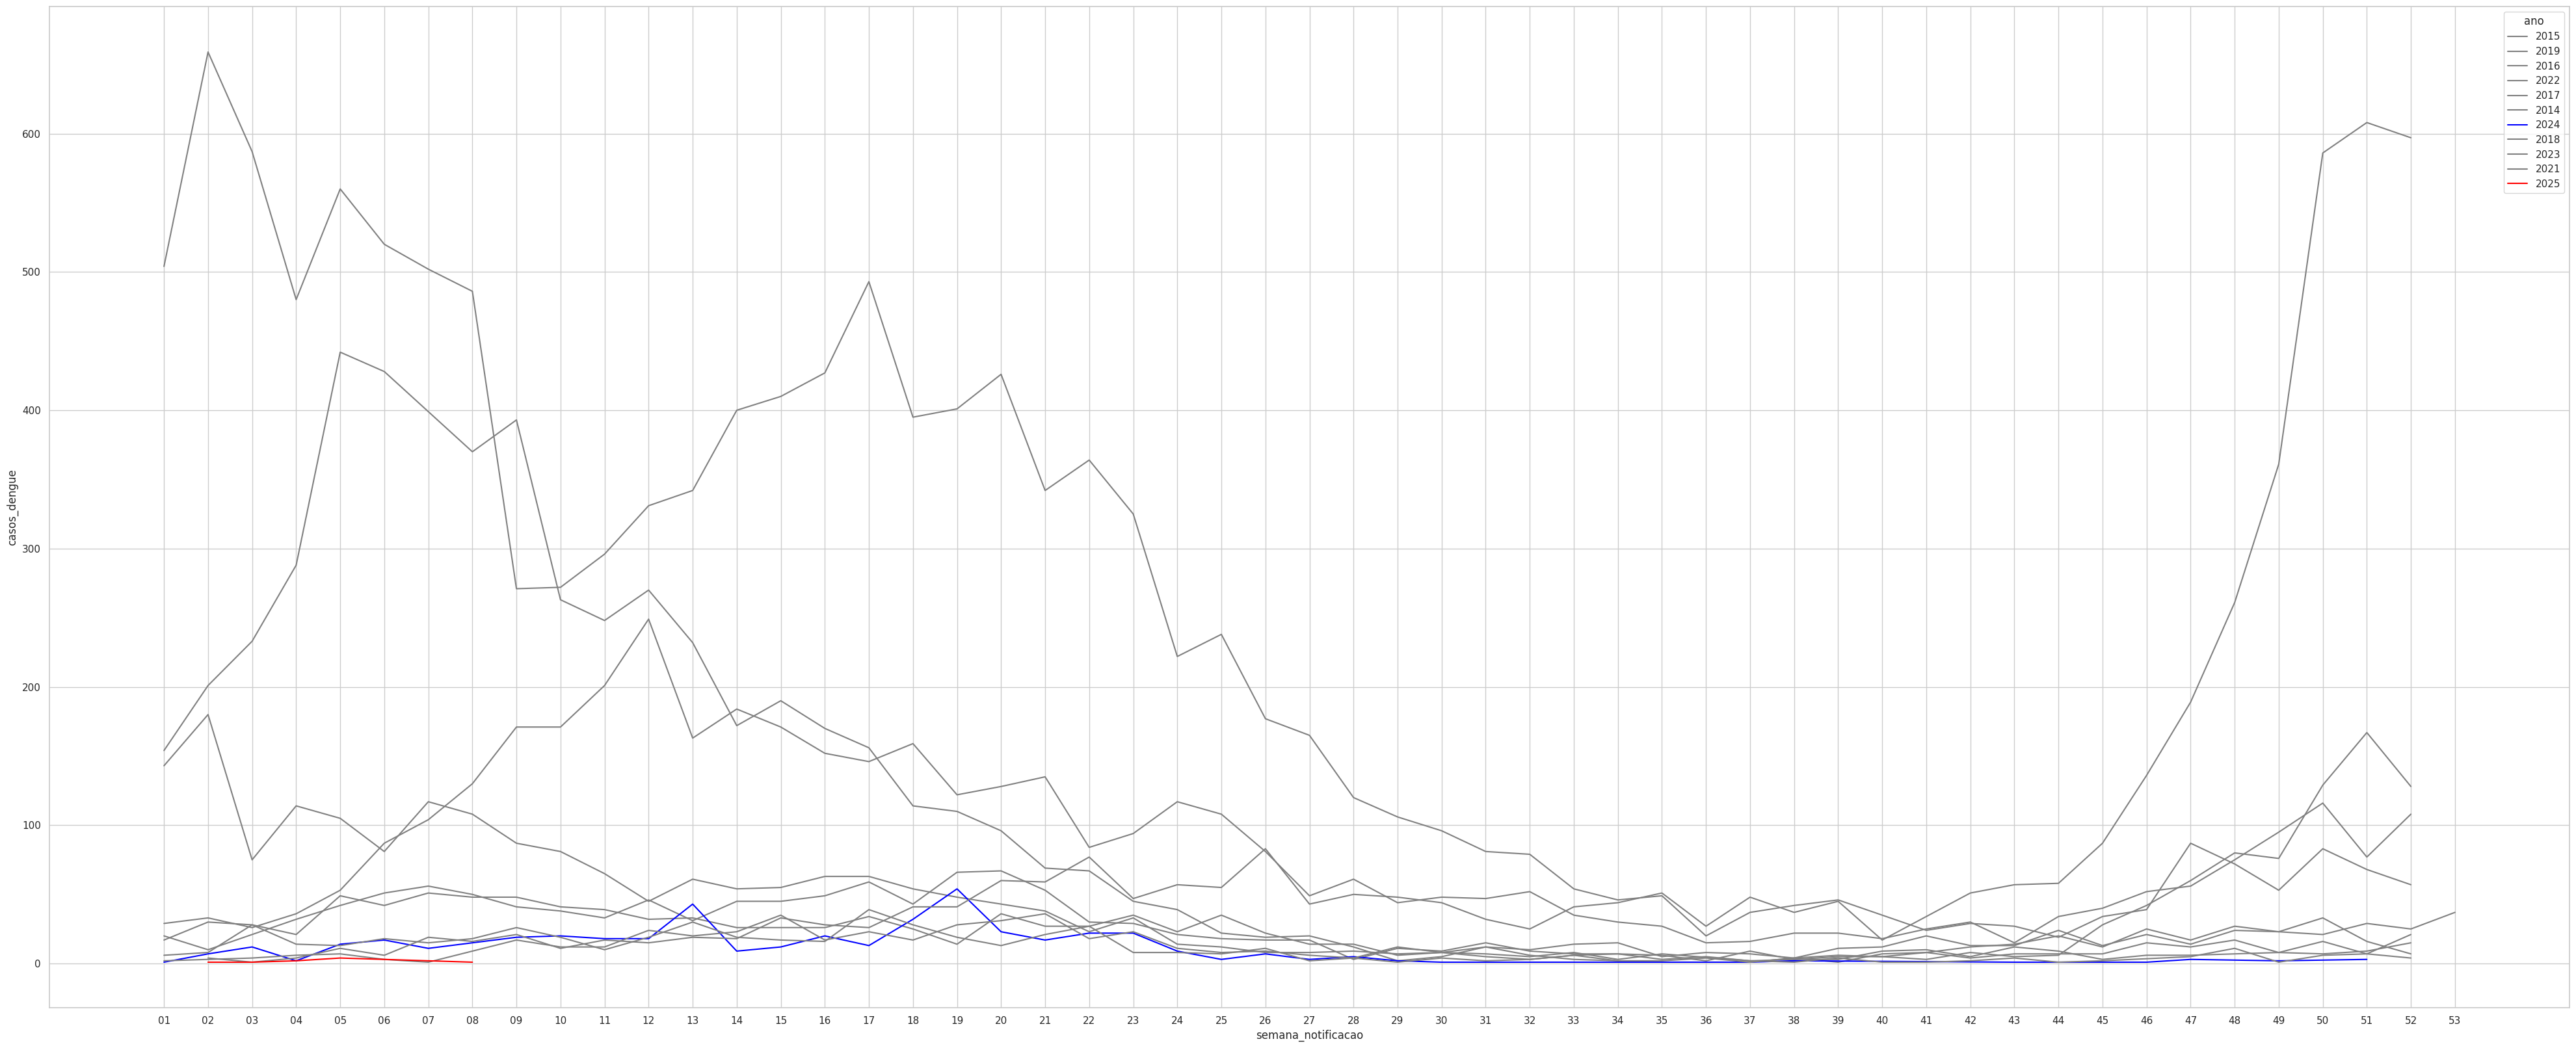

In [ ]:
sns.lineplot(data = df_semana_palmas, x = 'semana_notificacao', y = 'casos_dengue', hue = 'ano', palette = cores)
sns.set_theme(style="whitegrid", rc={'figure.figsize':(20,50)})

# Total de casos por regiões do país

In [ ]:
consulta = """
SELECT
  ano,
  nome_regiao,
  id_municipio_notificacao,
  COUNT(tipo_notificacao) AS total_casos,
  COUNT(CASE WHEN evolucao_caso = '2' THEN 1 END) AS total_obitos
FROM `basedosdados.br_ms_sinan.microdados_dengue` dengue
JOIN `basedosdados.br_bd_diretorios_brasil.municipio` municipio
ON dengue.sigla_uf_notificacao = municipio.sigla_uf AND dengue.id_municipio_notificacao = municipio.id_municipio
WHERE dengue.classificacao_final IN ("10", "11", "12")
AND dengue.tipo_notificacao = "2"
GROUP BY ano, nome_regiao, id_municipio_notificacao;
"""
df2 = bd.read_sql(consulta, billing_project_id = 'eleicoes-434413')

Downloading: 100%|██████████|


In [ ]:
df2

,ano,nome_regiao,id_municipio_notificacao,total_casos,total_obitos
0,2021,Norte,1200138,54,0
1,2021,Nordeste,2700102,1,0
2,2021,Nordeste,2708501,23,0
3,2021,Nordeste,2708600,315,2
4,2021,Norte,1304237,13,0
...,...,...,...,...,...
40916,2016,Nordeste,2600609,1,0
40917,2016,Nordeste,2608305,1,0
40918,2016,Nordeste,2606309,10,0
40919,2016,Nordeste,2615102,1,0


In [ ]:
# Ordenando a série histórica
df_final = df2.sort_values(by=['id_municipio_notificacao', 'ano'])

In [ ]:
df_final.head(11)

,ano,nome_regiao,id_municipio_notificacao,total_casos,total_obitos
31748,2014,Norte,1100015,8,0
5556,2015,Norte,1100015,10,0
33457,2016,Norte,1100015,11,0
19292,2017,Norte,1100015,9,0
33045,2018,Norte,1100015,1,0
6932,2019,Norte,1100015,227,0
19189,2020,Norte,1100015,3,0
28165,2021,Norte,1100015,2,0
23268,2022,Norte,1100015,365,0
35998,2023,Norte,1100015,379,1


In [ ]:
df_regiao = df_final.groupby(['ano', 'nome_regiao']).agg({
    'total_casos': ['sum', 'mean', 'median', 'std', 'min', 'max'],
    'total_obitos': ['sum', 'mean', 'median', 'std', 'min', 'max']
}).reset_index()

In [ ]:
df_regiao.columns = ['_'.join(col).strip() for col in df_regiao.columns.values]

In [ ]:
df_regiao

,ano_,nome_regiao_,total_casos_sum,total_casos_mean,total_casos_median,total_casos_std,total_casos_min,total_casos_max,total_obitos_sum,total_obitos_mean,total_obitos_median,total_obitos_std,total_obitos_min,total_obitos_max
0,2014,Centro-Oeste,84008,264.176101,20.5,1097.129372,1,13184,120,0.377358,0.0,3.251167,0,53
1,2014,Nordeste,55583,79.065434,6.0,386.219313,1,5898,151,0.214794,0.0,1.71077,0,29
2,2014,Norte,38262,223.754386,9.0,2052.093106,1,26792,17,0.099415,0.0,0.590662,0,7
3,2014,Sudeste,261534,295.185102,15.0,1939.077403,1,43127,165,0.18623,0.0,0.962736,0,15
4,2014,Sul,18659,82.561947,5.0,325.630053,1,3674,12,0.053097,0.0,0.293355,0,3
5,2015,Centro-Oeste,151259,377.204489,55.0,1618.192182,1,24520,153,0.381546,0.0,3.241382,0,55
6,2015,Nordeste,202999,200.39388,16.0,1263.037413,1,27531,159,0.15696,0.0,1.652655,0,40
7,2015,Norte,25069,96.419231,10.0,420.469591,1,4567,20,0.076923,0.0,0.342946,0,3
8,2015,Sudeste,901683,728.338449,67.0,3498.401646,1,67734,622,0.502423,0.0,2.847724,0,52
9,2015,Sul,42805,100.011682,8.0,311.005693,1,3127,26,0.060748,0.0,0.42855,0,6


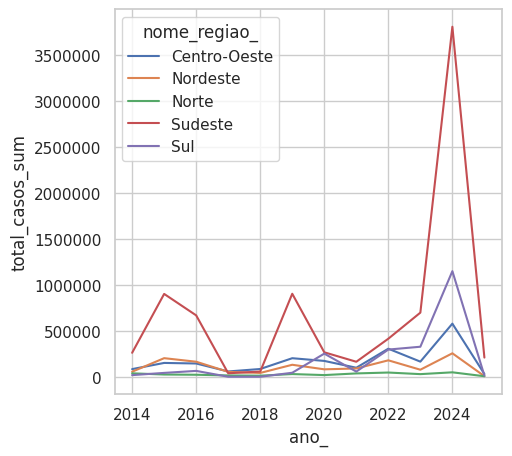

In [ ]:
sns.lineplot(data=df_regiao, x='ano_', y='total_casos_sum', hue='nome_regiao_')
sns.set_theme(style="whitegrid", rc={'figure.figsize': (10, 5)})

plt.ticklabel_format(style='plain', axis='y')  # Remove notação científica do eixo Y
plt.show()

# Estatísticas do Brasil

Consulta no SQL:

```
SELECT ano, COUNT(tipo_notificacao) as casos_dengue
FROM `basedosdados.br_ms_sinan.microdados_dengue`
WHERE (ano = 2023 OR ano = 2024) AND classificacao_final IN ("10", "11", "12")
AND tipo_notificacao = "2"
GROUP BY ano
ORDER BY ano DESC;
```



In [ ]:
# Dados
casos_2024 = 5839790
casos_2023 = 1297582

# Cálculo do aumento percentual
aumento_percentual = ((casos_2024 - casos_2023) / casos_2023) * 100

# Exibir resultado
print(f"Aumento percentual: {aumento_percentual:.2f}%")

Aumento percentual: 350.05%


# Casos Brasil

In [ ]:
consulta = """
SELECT ano, semana_notificacao, COUNT(tipo_notificacao) as casos_dengue
FROM `basedosdados.br_ms_sinan.microdados_dengue`
WHERE classificacao_final IN ("10", "11", "12")
AND tipo_notificacao = "2"
GROUP BY ano, semana_notificacao
ORDER BY ano, semana_notificacao DESC
"""
brasil = bd.read_sql(consulta, billing_project_id = 'eleicoes-434413')

Downloading: 100%|██████████|


In [ ]:
brasil

,ano,semana_notificacao,casos_dengue
0,2014,53,3221
1,2014,52,2448
2,2014,51,3428
3,2014,50,3418
4,2014,49,3376
...,...,...,...
531,2025,05,40793
532,2025,04,36352
533,2025,03,32010
534,2025,02,27110


In [ ]:
brasil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ano                 536 non-null    Int64 
 1   semana_notificacao  535 non-null    object
 2   casos_dengue        536 non-null    Int64 
dtypes: Int64(2), object(1)
memory usage: 13.7+ KB


In [ ]:
# split the Name column into two columns
brasil[['ano', 'semana_notificacao']] = brasil['semana_notificacao'].str.split('-', expand=True)

In [ ]:
brasil['semana_notificacao'] = brasil['semana_notificacao'].astype(str)

In [ ]:
brasil_comp = brasil.loc[brasil['semana_notificacao'].astype(int) <= 5]

In [ ]:
brasil_comp

,ano,semana_notificacao,casos_dengue
47,2023,05,18542
48,2023,04,15149
49,2023,03,12181
50,2023,02,10007
51,2023,01,5255
99,2024,05,124001
100,2024,04,92393
101,2024,03,63105
102,2024,02,44374
103,2024,01,21669


In [ ]:
casos_primeiras_semanas = brasil_comp.groupby('ano')['casos_dengue'].sum().reset_index()

In [ ]:
casos_primeiras_semanas

,ano,casos_dengue,aumento_percentual
0,2023,61134,<NA>
1,2024,345542,465.220663
2,2025,147377,-57.349034


In [ ]:
# Calcular o aumento percentual em relação ao ano anterior
casos_primeiras_semanas['aumento_percentual'] = casos_primeiras_semanas['casos_dengue'].pct_change() * 100

In [ ]:
brasil_chart = brasil.groupby(['ano']).agg({'casos_dengue': 'sum'}).reset_index()

In [ ]:
brasil_chart

,ano,casos_dengue
0,1415,1
1,2014,458045
2,2015,1323818
3,2016,1065165
4,2017,167604
5,2018,198402
6,2019,1311744
7,2021,447837
8,2022,1243397
9,2023,1297582


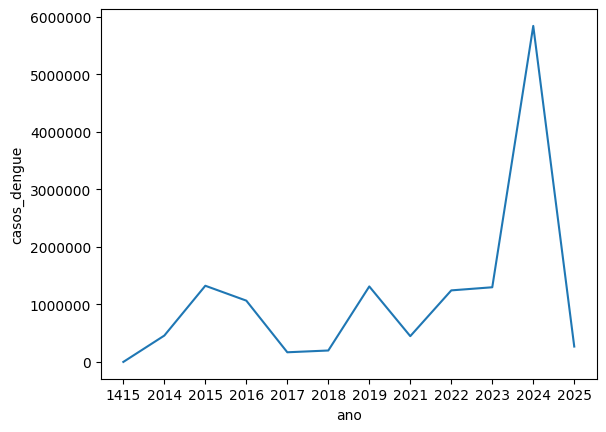

In [ ]:
sns.lineplot(data = brasil_chart, x = 'ano', y = 'casos_dengue')
sns.set_theme(style="whitegrid", rc={'figure.figsize': (10, 5)})

plt.ticklabel_format(style='plain', axis='y')  # Remove notação científica do eixo Y
plt.show()